In [109]:
# HH Single Test
# 1 Use numpy only to reveal the HH model
# 2 Set the path for network

import numpy as np
import matplotlib.pyplot as plt
import re
import os

In [110]:
# Constants
ms=1e-3
mV=1e-3
mA=1e-3
nA=1e-9
pA=1e-12
nS=1e-9
pF=1e-12

# Variables
# 总的神经元数量
Num=100
# 输入的最大幅值
AmpStim=200 # 80,92
# 输入的持续时间
plat = 1000
# 输入的噪声强度
TauP=100
# 静息时的输入强度
rest=30
# 突触的传递时间
tau_S=10.0

# whole world time
tick_time=0
# minium gap time3
dt=0.1*ms
# total time
TotTime=4000*ms
# time of fire
fire1_num=0
fire2_num=0
time_sim=np.arange(0, TotTime, dt)
# average data analysis
bin_num=1000
N1=int(Num*0.2)
N2=int(Num*0.8)
N_in=int(Num*0.8)
test_input_index=0

global fire_matrix1, fire_matrix2
fire_matrix1=np.zeros((N1, len(time_sim)))
fire_matrix2=np.zeros((N2, len(time_sim)))

In [111]:
def bin_data(data):
    try:
        return np.mean(data[len(data)-bin_num:len(data)])
    except:
        return data[len(data)-1]

def extract_number_from_string(s):
    match = re.search(r'_(\d+)$', s)
    if match:
        return int(match.group(1))
    else:
        return None

In [112]:
class HHNeuron:
    def __init__(self, name, V_Neuron, G_Synapsis_Excitatory, G_Synapsis_Inhibitory, 
                 E_Excitatory, E_Inhibitory, E_local, G_local, V_Excitatory_Threshold,C_Membrane, 
                 tau_Synapsis,
                 V_Reset_Threshold,
                 I_Synapsis, T_rest,
                 Connecting_Neuron, Q_Synapsis, Probability_Connecting,
                 G_Synapsis_K, G_Synapsis_Na, E_K, E_Na,
                 n_coefficient, m_coefficient, h_coefficient):
        # variable parameters
        self.name = name
        self.V_Neuron = V_Neuron
        self.G_Synapsis_Excitatory = G_Synapsis_Excitatory
        self.G_Synapsis_Inhibitory = G_Synapsis_Inhibitory
        # fixed parameters
        self.E_Excitatory = E_Excitatory
        self.E_Inhibitory = E_Inhibitory
        self.E_local = E_local
        self.G_local = G_local
        self.V_Excitatory_Threshold = V_Excitatory_Threshold
        self.C_Membrane = C_Membrane
        # adaptive parameters
        self.tau_Synapsis = tau_Synapsis
        # reset parameters
        self.V_Reset_Threshold = V_Reset_Threshold
        self.I_Synapsis = I_Synapsis
        self.T_rest = T_rest
        # connecting neurons
        self.Connecting_Neuron = Connecting_Neuron
        self.Q_Synapsis = Q_Synapsis
        self.Probability_Connecting = Probability_Connecting
        # HH model parameters
        self.G_Synapsis_K = G_Synapsis_K
        self.G_Synapsis_Na = G_Synapsis_Na
        self.E_K = E_K
        self.E_Na = E_Na
        self.n_coefficient = n_coefficient
        self.m_coefficient = m_coefficient
        self.h_coefficient = h_coefficient
    def refresh_membrane_potential(self):
        self.V_Neuron =self.V_Neuron+dt*(self.G_Synapsis_Excitatory*(self.E_Excitatory-self.V_Neuron)+
                                        self.G_Synapsis_Inhibitory*(self.E_Inhibitory-self.V_Neuron)+
                                        self.G_local*(self.E_local-self.V_Neuron)+
                                        self.G_Synapsis_K*self.n_coefficient*self.n_coefficient*self.n_coefficient*self.n_coefficient*(self.E_K-self.V_Neuron)+
                                        self.G_Synapsis_Na*self.m_coefficient*self.m_coefficient*self.m_coefficient*self.h_coefficient*(self.E_Na-self.V_Neuron)+
                                        self.I_Synapsis
                                        )/self.C_Membrane
        if self.V_Neuron<-50*mV:
            self.T_rest=0
    def refresh_G_Synapsis_Excitatory(self):
        self.G_Synapsis_Excitatory = self.G_Synapsis_Excitatory-dt*self.G_Synapsis_Excitatory/self.tau_Synapsis
    def refresh_G_Synapsis_Inhibitory(self):
        self.G_Synapsis_Inhibitory = self.G_Synapsis_Inhibitory-dt*self.G_Synapsis_Inhibitory/self.tau_Synapsis
    def refresh_n_coefficient(self):
        self.n_coefficient = self.n_coefficient+dt*(0.032/mV*(15*mV-self.V_Neuron+self.V_Excitatory_Threshold)/(np.exp((15*mV-self.V_Neuron+self.V_Excitatory_Threshold)/5/mV)-1)*(1-self.n_coefficient)/ms
                                                        -0.5*np.exp((10*mV-self.V_Neuron+self.V_Excitatory_Threshold)/40/mV)*self.n_coefficient/ms)
    def refresh_h_coefficient(self):
        self.h_coefficient = self.h_coefficient+dt*(0.128*np.exp((17*mV-self.V_Neuron+self.V_Excitatory_Threshold)/18/mV)*(1-self.h_coefficient)/ms
                                                        -4/(1+np.exp((40*mV-self.V_Neuron+self.V_Excitatory_Threshold)/5/mV))*self.h_coefficient/ms)
    def refresh_m_coefficient(self):
        self.m_coefficient = self.m_coefficient+dt*(0.32/mV*(13*mV-self.V_Neuron+self.V_Excitatory_Threshold)/(np.exp((13*mV-self.V_Neuron+self.V_Excitatory_Threshold)/4/mV)-1)*(1-self.m_coefficient)/ms
                                                        -0.28/mV*(self.V_Neuron-self.V_Excitatory_Threshold-40*mV)/(np.exp((self.V_Neuron-self.V_Excitatory_Threshold-40*mV)/5/mV)-1)*self.m_coefficient/ms)
    def fire(self, num1, num2):
        global fire_matrix
        # refresh self parameter
        # print(self.name)
        if self.name[1]=='1':
            num1=num1+1
            fire_matrix1[extract_number_from_string(self.name)-1,test_input_index]=2
            for neuron1 in self.Connecting_Neuron:
                neuron1.G_Synapsis_Inhibitory=neuron1.G_Synapsis_Inhibitory+self.Q_Synapsis
        if self.name[1]=='2':
            num2=num2+1
            fire_matrix2[extract_number_from_string(self.name)-1,test_input_index]=2
            for neuron2 in self.Connecting_Neuron:
                neuron2.G_Synapsis_Excitatory=neuron2.G_Synapsis_Excitatory+self.Q_Synapsis
        return num1, num2
    def judge_fire(self, num1, num2):
        if self.T_rest==0:
            if self.V_Neuron>self.V_Reset_Threshold:
                num1, num2=self.fire(num1, num2)
                self.T_rest=1
        else:
            pass
        return num1, num2
    def Add_Synapsis(self, Synapsis):
        self.Connecting_Neuron.append(Synapsis)

In [113]:
FS_HH_neuron=HHNeuron(name="G1_1", V_Neuron=-65*mV, G_Synapsis_Excitatory=0, G_Synapsis_Inhibitory=0, 
                 E_Excitatory=0*mV, E_Inhibitory=-80*mV, E_local=-65*mV, G_local=10*nS, V_Excitatory_Threshold=-50*mV,C_Membrane=200*pF, 
                 tau_Synapsis=5*ms,
                 V_Reset_Threshold=-10*mV,
                 I_Synapsis=0.13*nA, T_rest=0,
                 Connecting_Neuron=[], Q_Synapsis=5*nS, Probability_Connecting=0.05,
                 G_Synapsis_K=6000*nS, G_Synapsis_Na=20000*nS, E_K=-90*mV, E_Na=55*mV,
                 n_coefficient=0, m_coefficient=0, h_coefficient=0)

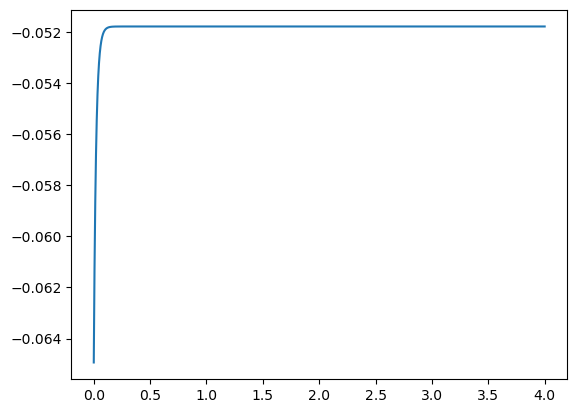

In [114]:
single_membrane_potential=[]
n=[]
m=[]
h=[]
for tick_time in time_sim:
    FS_HH_neuron.refresh_membrane_potential()
    FS_HH_neuron.refresh_G_Synapsis_Excitatory()
    FS_HH_neuron.refresh_G_Synapsis_Inhibitory()
    FS_HH_neuron.refresh_n_coefficient()
    FS_HH_neuron.refresh_h_coefficient()
    FS_HH_neuron.refresh_m_coefficient()
    FS_HH_neuron.judge_fire(0,0)
    single_membrane_potential.append(FS_HH_neuron.V_Neuron)
    n.append(FS_HH_neuron.n_coefficient)
    m.append(FS_HH_neuron.m_coefficient)
    h.append(FS_HH_neuron.h_coefficient)

plt.plot(time_sim, single_membrane_potential)
plt.show()

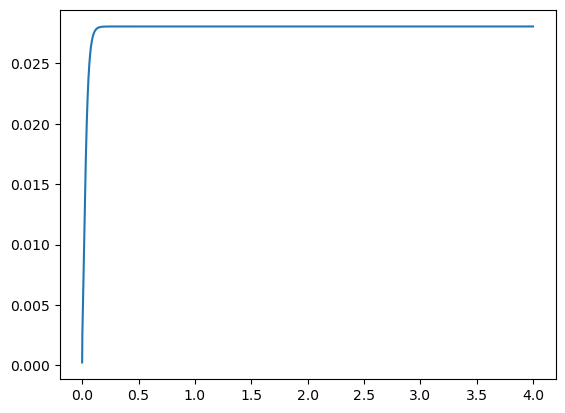

In [115]:
plt.plot(time_sim, n)

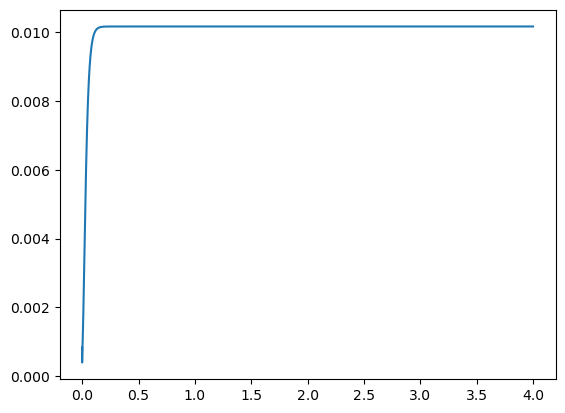

In [116]:
plt.plot(time_sim, m)

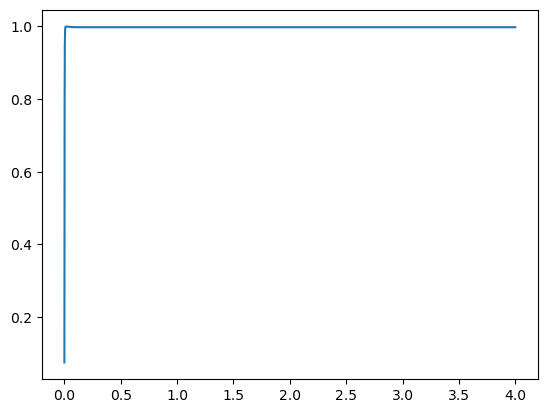

In [117]:
plt.plot(time_sim, h)